## Learning about Pystan

Sources:
- [An Introduction to Bayesian Inference in Pystan](https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
import pystan

In [3]:
# Stan model specification

model = """

data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    y ~ normal(alpha + beta*x, sigma);
}
"""

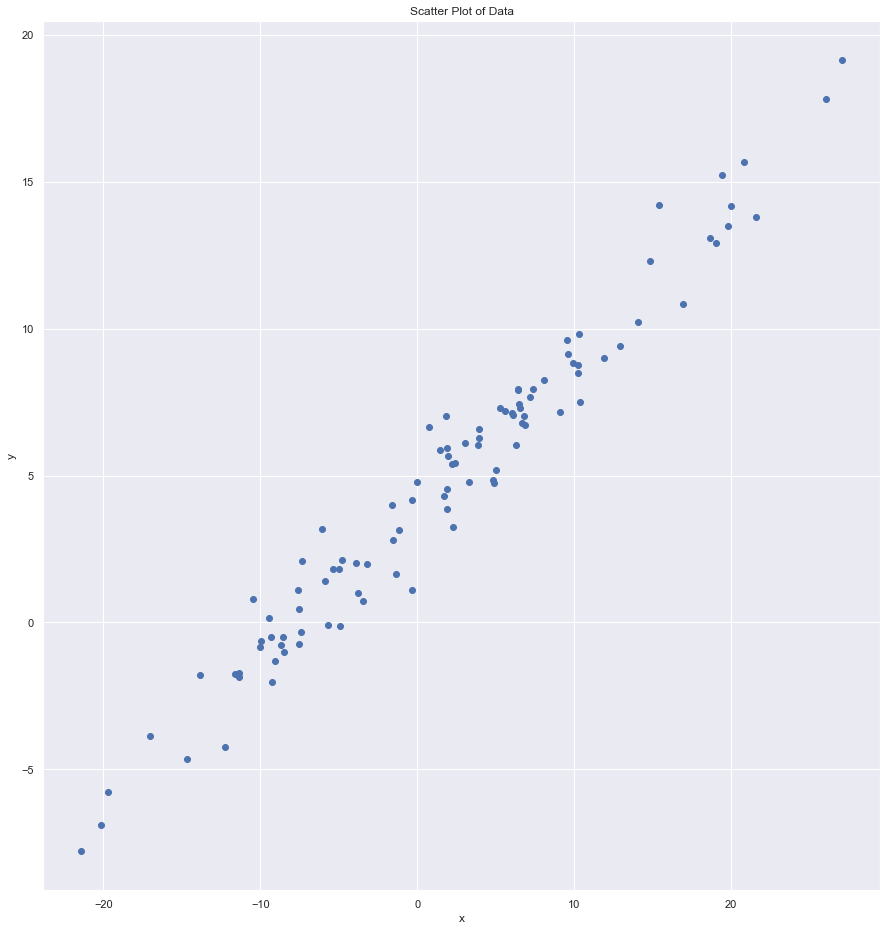

In [4]:
# Data generation

# Set seed for reproducibility
np.random.seed(101)

# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot
x = 10 * np.random.randn(100)
y = alpha + beta * x
y = np.random.normal(y, scale = sigma)

plt.figure(figsize=(15,16))

plt.scatter(x,y)

plt.title('Scatter Plot of Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
# Put data in a dictionary
data = {'N' : len(x), 
        'x' : x,
        'y' : y}

# Compile model
sm = pystan.StanModel(model_code = model)

# Train model and generate samples
fit = sm.sampling(data=data, 
                 iter=1000, 
                 chains=4, 
                 warmup=500,
                 thin=1,
                 seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d1e6a3398ed08f7d9ea6b711bb5865bd NOW.


In [6]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'],
                 columns = summary_dict['summary_colnames'],
                 index = summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting Traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

Text(0.5, 1.0, 'Fitted Regression Line')

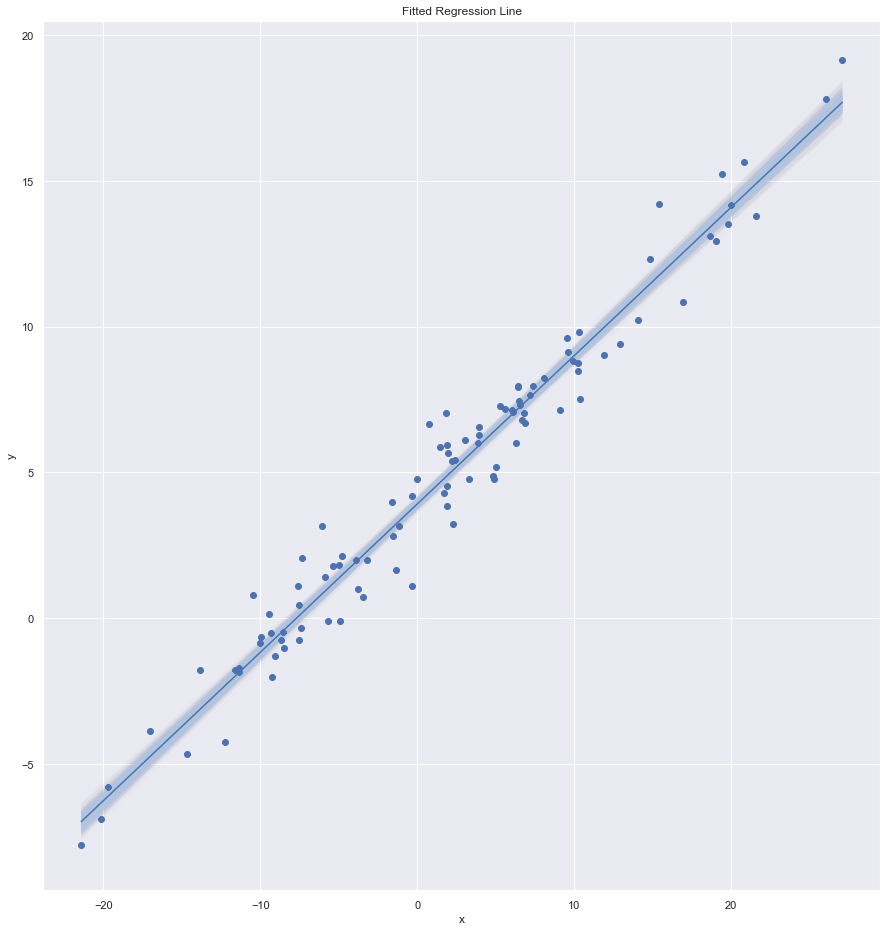

In [7]:
# Plotting regression line
x_max, x_min = np.max(x), np.min(x)
x_plot = np.linspace(x_min, x_max, 100)

# Plot subset of sampled regression lines
plt.figure(figsize=(15,16))
np.random.shuffle(alpha), np.random.shuffle(beta)

for i in range(1000):
    plt.plot(x_plot, alpha[i] + beta[i] * x_plot, 
            color = 'lightsteelblue',
            alpha = 0.005)

# Plot mean regression line
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Regression Line')

In [8]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter"""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.figure(figsize=(17,21))
    
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color = 'r', lw = 2, linestyle = '--')
    plt.axhline(median, color = 'c', lw = 2, linestyle = '--')
    plt.axhline(cred_min, color = 'k', linestyle = ':', alpha = 0.2)
    plt.axhline(cred_max, color = 'k', linestyle = ':', alpha = 0.2)
    plt.title(f'Trace and Posterior Distribution for {param_name}')
    
    plt.subplot(2,1,2)
    plt.hist(param, 30, density = True); sns.kdeplot(param, shade = True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color = 'r', lw = 2, linestyle = '--', label = 'mean')
    plt.axvline(median, color = 'c', lw = 2, linestyle = '--', label = 'median')
    plt.axvline(cred_min, color = 'k', linestyle = ':', alpha = 0.2, label = '95% CI')
    plt.axvline(cred_max, color = 'k', linestyle = ':', alpha = 0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

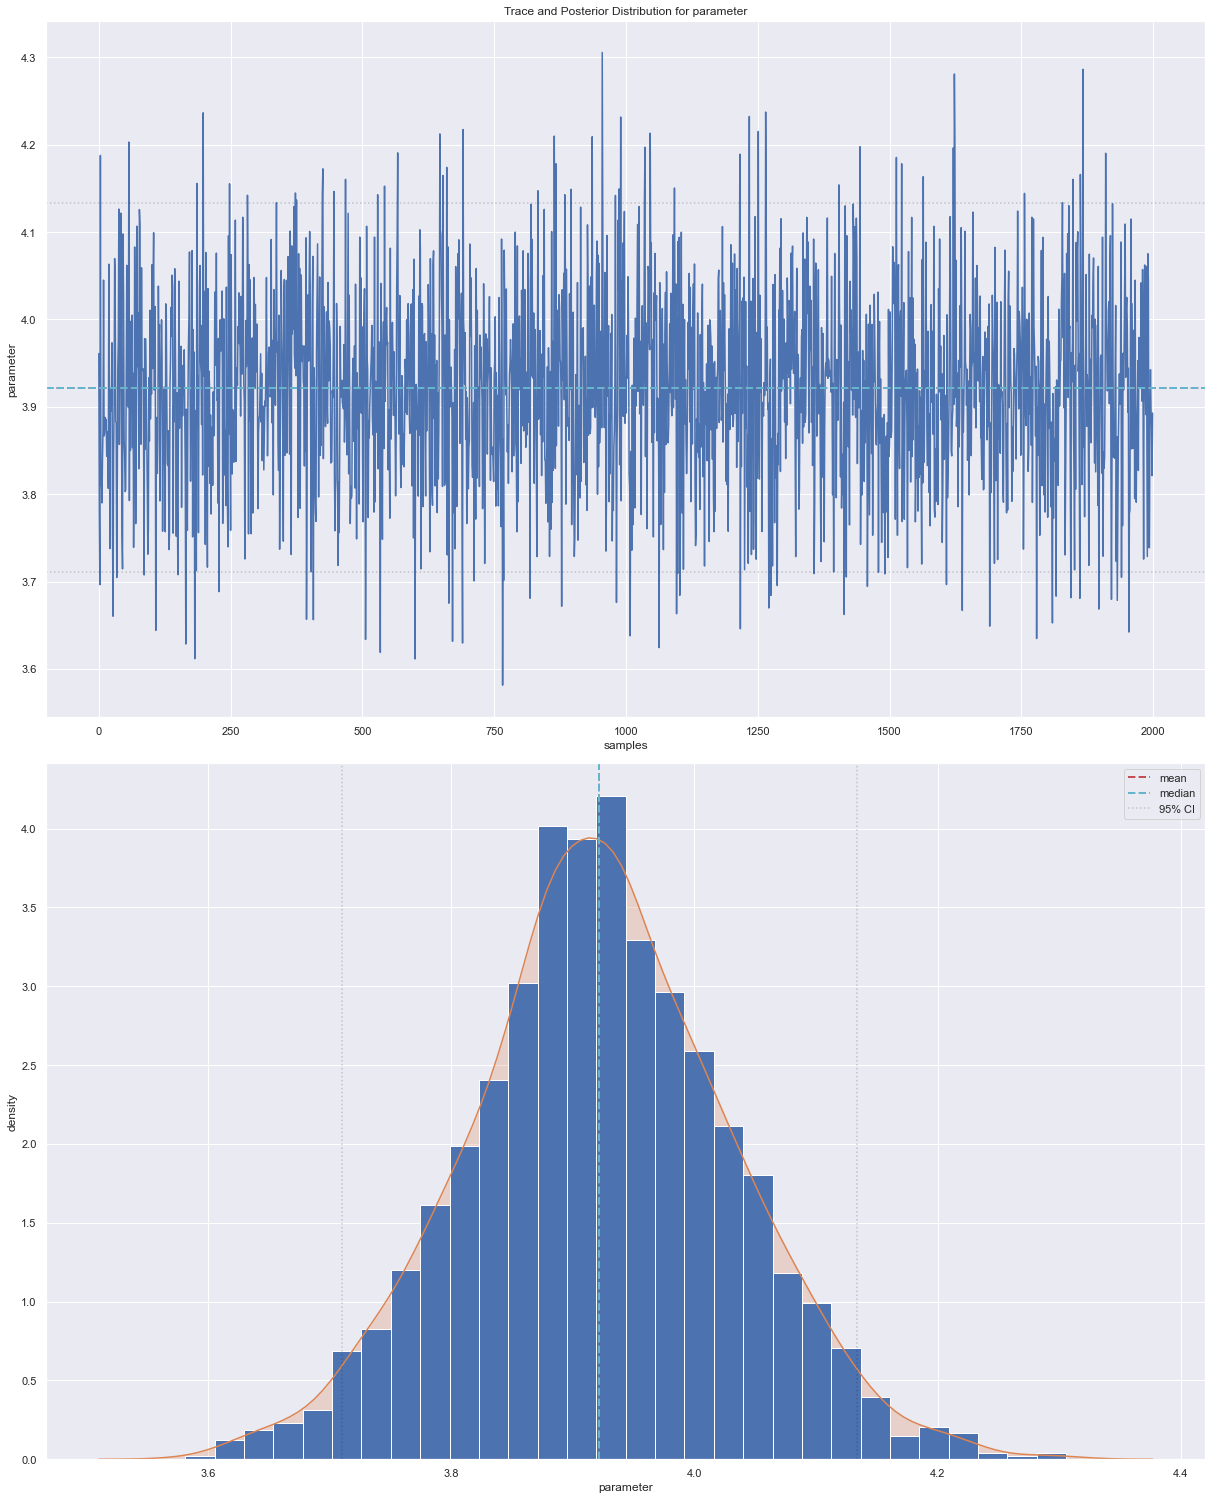

In [9]:
plot_trace(alpha, param_name='parameter')

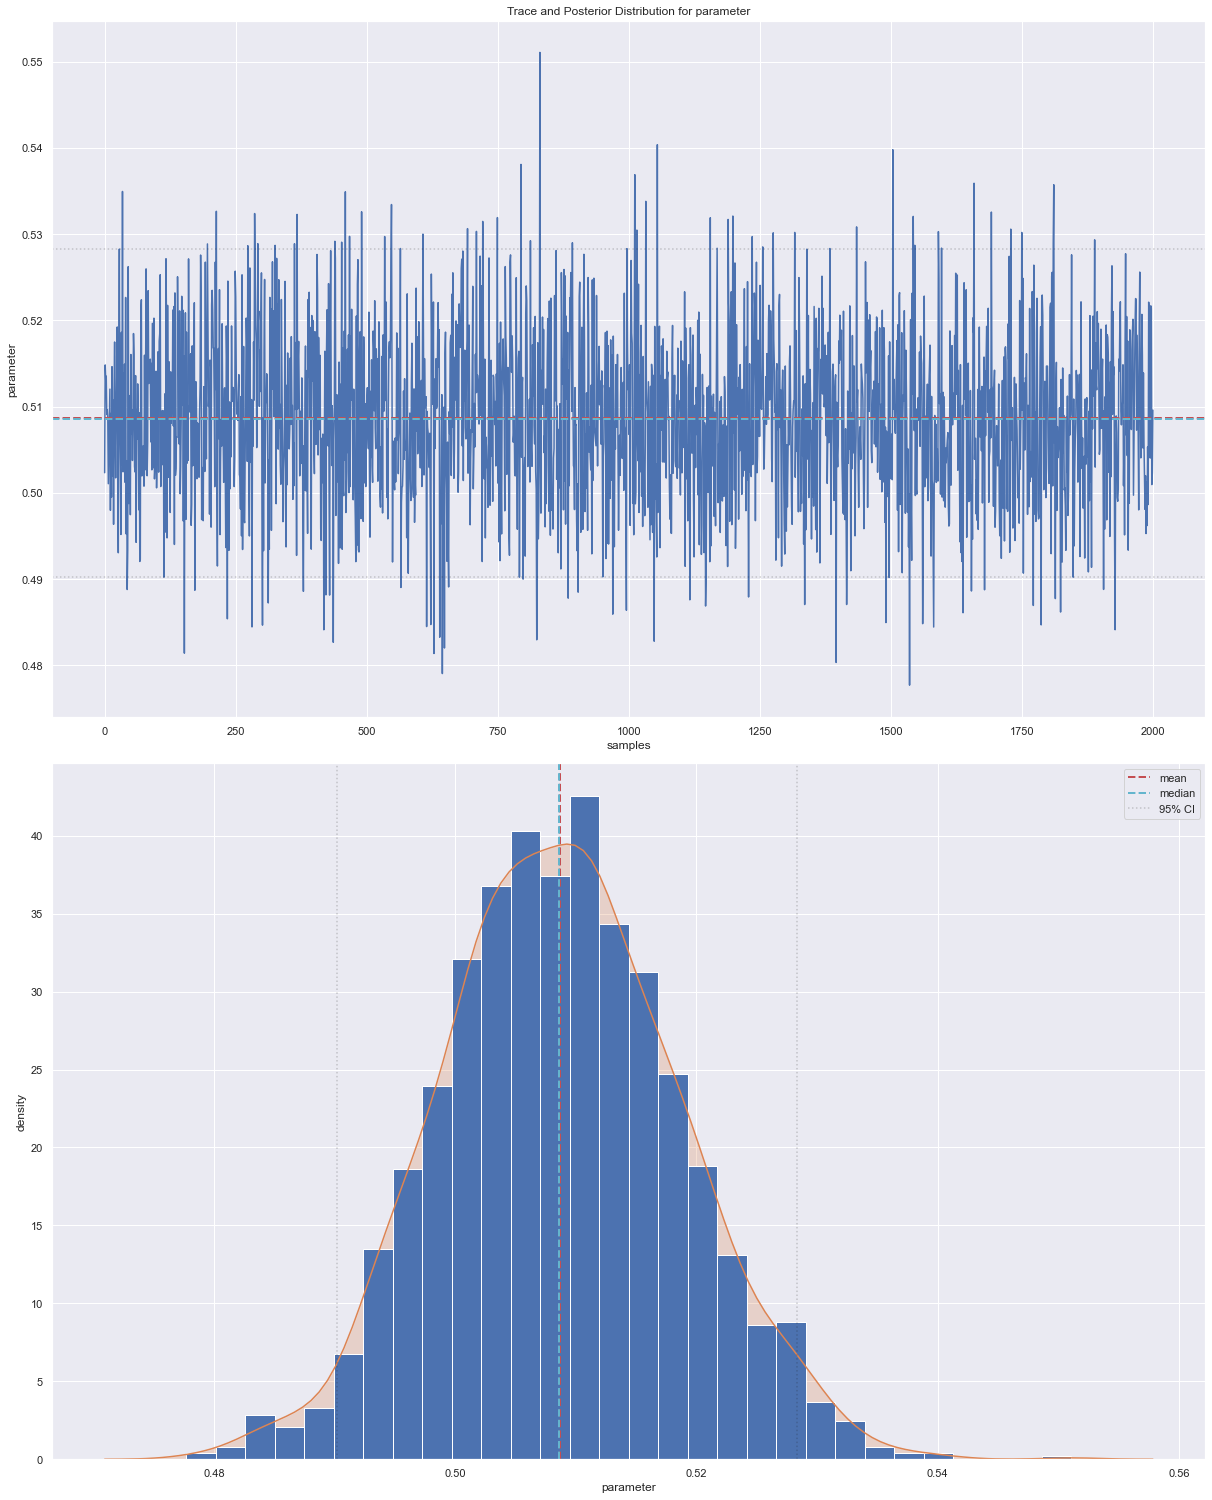

In [10]:
plot_trace(beta, param_name='parameter')

In [11]:
data = pd.read_csv('../data_cleaned.csv')

In [12]:
data

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,st_ct,mrkdn_valadd_edw,mrkdn_pdm,va_pub_0.15,va_pub_0.2,va_pub_0.25,va_pub_0.3,Electronics,unemployment_rate,is_holiday_week
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,716.285714,0.000000,0.368029,1,0,0,0,63,7.0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,716.428571,0.000000,0.360911,1,0,0,0,54,7.0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,717.000000,0.000000,0.344832,1,1,0,0,54,7.0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,717.000000,0.000000,0.356973,1,1,0,0,45,7.0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,717.000000,0.000000,0.359990,0,1,0,0,52,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2018-07-01,2018,2,5,5,22,13038,13828188,387,2135131,...,599.000000,0.415964,0.371423,0,1,0,0,41,5.8,1
205,2018-07-08,2018,2,6,1,23,0,3714294,0,1448480,...,599.000000,0.457615,0.372676,0,1,1,0,45,5.8,1
206,2018-07-15,2018,2,6,2,24,2225092,5102353,0,1307764,...,599.000000,0.382469,0.363597,0,0,1,0,47,5.8,0
207,2018-07-22,2018,2,6,3,25,17544331,1478566,1891,510539,...,599.000000,0.272084,0.360448,0,1,0,0,44,5.8,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wk_strt_dt         209 non-null    object 
 1   yr_nbr             209 non-null    int64  
 2   qtr_nbr            209 non-null    int64  
 3   prd                209 non-null    int64  
 4   wk_nbr             209 non-null    int64  
 5   wk_in_yr_nbr       209 non-null    int64  
 6   mdip_dm            209 non-null    int64  
 7   mdip_inst          209 non-null    int64  
 8   mdip_nsp           209 non-null    int64  
 9   mdip_auddig        209 non-null    int64  
 10  mdip_audtr         209 non-null    int64  
 11  mdip_vidtr         209 non-null    int64  
 12  mdip_viddig        209 non-null    int64  
 13  mdip_so            209 non-null    int64  
 14  mdip_on            209 non-null    int64  
 15  mdip_em            209 non-null    int64  
 16  mdip_sms           209 non

In [14]:
data['wk_strt_dt'] = pd.to_datetime(data['wk_strt_dt'])

In [15]:
df = data.iloc[:,6:39]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mdip_dm           209 non-null    int64  
 1   mdip_inst         209 non-null    int64  
 2   mdip_nsp          209 non-null    int64  
 3   mdip_auddig       209 non-null    int64  
 4   mdip_audtr        209 non-null    int64  
 5   mdip_vidtr        209 non-null    int64  
 6   mdip_viddig       209 non-null    int64  
 7   mdip_so           209 non-null    int64  
 8   mdip_on           209 non-null    int64  
 9   mdip_em           209 non-null    int64  
 10  mdip_sms          209 non-null    int64  
 11  mdip_aff          209 non-null    int64  
 12  mdip_sem          209 non-null    int64  
 13  mdsp_dm           209 non-null    float64
 14  mdsp_inst         209 non-null    float64
 15  mdsp_nsp          209 non-null    float64
 16  mdsp_auddig       209 non-null    float64
 1

<AxesSubplot:>

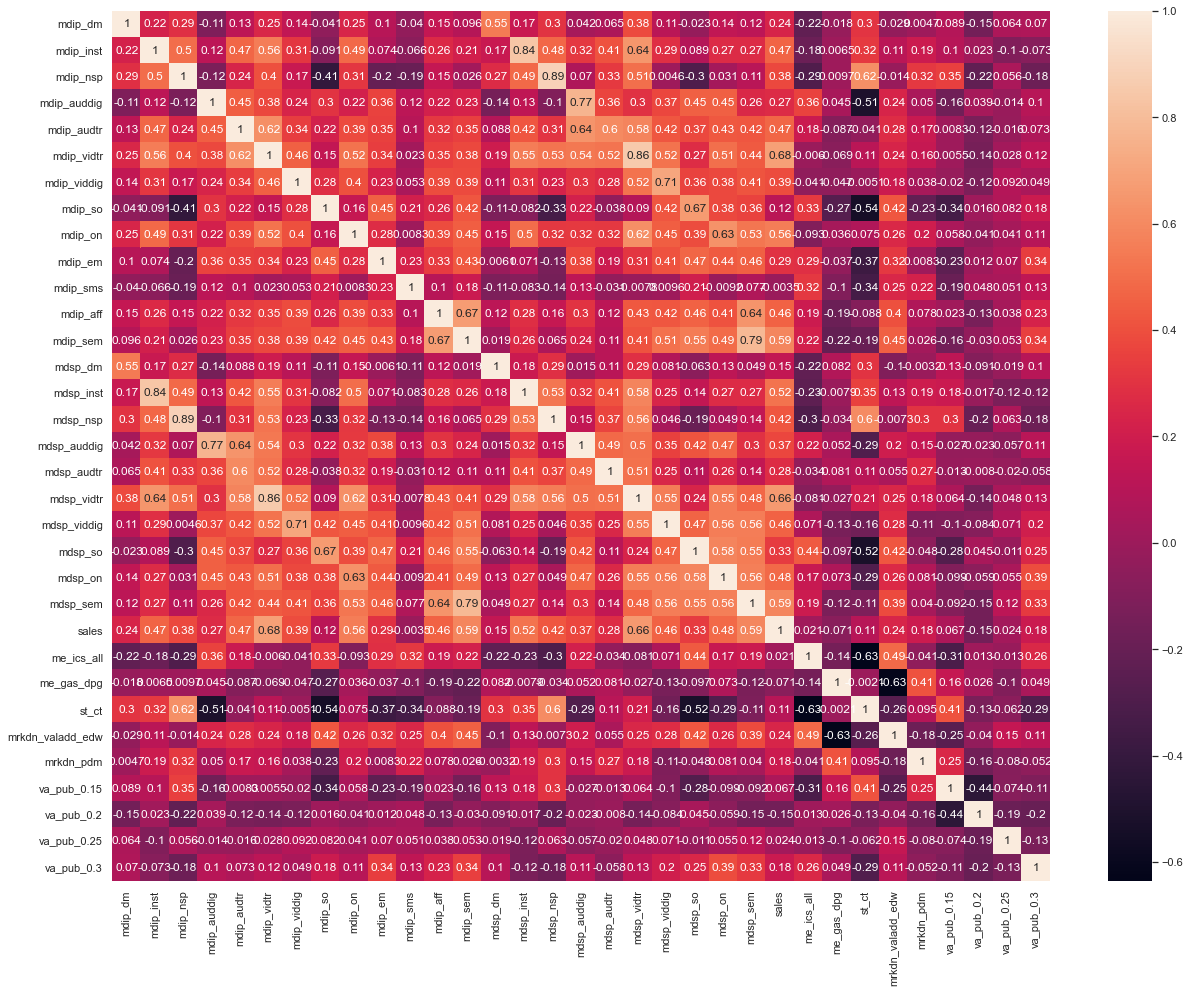

In [34]:
fig, ax = plt.subplots(figsize=(21, 16))

sns.heatmap(df.corr(), annot=True, ax = ax)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [18]:
X, y = df.drop(['sales'], axis = 1), df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [19]:
X_train

,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,mdip_audtr,mdip_vidtr,mdip_viddig,mdip_so,mdip_on,mdip_em,...,mdsp_sem,me_ics_all,me_gas_dpg,st_ct,mrkdn_valadd_edw,mrkdn_pdm,va_pub_0.15,va_pub_0.2,va_pub_0.25,va_pub_0.3
74,1174464,5551680,3215391,177576,13474856,4670017,225369,5255152,3591533,2027258,...,563136.60,92.0,2.135,699.0,0.345017,0.339270,1,1,0,0
165,4635606,4675440,1044617,3368574,20718802,9610129,1174254,16983692,6678384,4524516,...,652846.69,100.7,2.682,600.0,0.398712,0.333847,0,1,0,0
119,23342889,17420880,1332313,1636545,22798185,15035080,1926157,28763568,9600362,7208236,...,1138013.94,93.8,2.298,665.0,0.459268,0.312714,0,1,0,0
16,17551954,62803626,6880524,929317,30785548,11391924,1321714,0,12197741,5004684,...,961115.10,88.8,2.907,719.0,0.421517,0.370766,1,1,0,0
208,30800,3106708,450,108614,940042,275872,20106,12657494,5260382,5541235,...,325930.71,97.9,2.924,599.0,0.325676,0.362766,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,19133674,6178240,4421164,987746,11148561,4908848,418176,12738315,3696126,4880620,...,397281.20,90.0,2.374,699.0,0.391951,0.336189,0,0,1,0
70,26886208,14782786,9847458,1188824,43985315,35814644,6486769,19599881,6222997,3802218,...,1366792.41,92.6,2.159,699.0,0.444180,0.351252,0,0,1,0
81,834033,6706560,581453,190008,12930439,815,128571,7917121,1550740,1721661,...,347753.64,91.7,1.837,666.0,0.360695,0.345288,0,1,0,0
11,8693516,6168866,3421621,298897,26066189,5925606,99815,0,3339834,2067077,...,559240.25,86.9,3.205,719.0,0.000000,0.351353,0,1,0,0


In [20]:
X_train_const = sm.add_constant(X_train)

model_ols = sm.OLS(y_train, X_train_const)

In [21]:
fit_ols = model_ols.fit_regularized(L1_wt=1)

In [22]:
X_test_const = sm.add_constant(X_test)
pred_ols = model_ols.predict(fit_ols.params, X_test_const)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [23]:
pred_ols_train = model_ols.predict(fit_ols.params, X_train_const)

In [24]:
r2_score(y_test, pred_ols)

0.37194144388952877

In [25]:
r2_score(y_train, pred_ols_train)

0.6761986912292596

In [26]:
mean_squared_error(y_test, pred_ols)

1393144994256208.8

In [27]:
mean_squared_error(y_train, pred_ols_train)

1020838668072961.9

In [31]:
# Stan model specification

model = """

data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] x;
    vector[N] y;
}

parameters {
    real alpha; // Intercept
    vector[K] beta; // Coefficients for Predictors
    real<lower=0> sigma; // Error Scale
}

model {
    y ~ normal(alpha + x * beta, sigma); // Likelihood
}
"""

In [32]:
# Put data in a dictionary
data = {'N' : X_train.shape[0],
        'K' : X_train.shape[1],
        'x' : X_train,
        'y' : y_train}

# Compile model
sm = pystan.StanModel(model_code = model)

# Train model and generate samples
fit = sm.sampling(data=data, 
                 iter=1000, 
                 chains=4, 
                 warmup=500,
                 thin=1,
                 seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0c45f5098252744f013f47f48cbce36b NOW.
